In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/Users/hinaljajal/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/hinaljajal/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
#Load data
sim_env_data = pd.read_csv('../../data/sim_env_v3_data.csv')
action_selection = pd.read_csv('../../data/Raw Pilot Data/action_selection_data_table.csv')
update_data = pd.read_csv('../../data/Raw Pilot Data/update_data_table.csv')
brush_data = pd.read_csv('../../data/Raw Pilot Data/lightyear_data_by_sessions.csv')


In [3]:
sim_env_data['date'] = pd.to_datetime(sim_env_data['decision_time']).dt.strftime("%Y-%m-%d")

## Plot 1: Average Dosage per Day

Average curve of average dose per day (group by day in study). X-axis is day in study from september 2023 to june 2024. Y-axis is average number of times algorithm selected action 1 averaged across all decision points for that day across all users currently in the study.

Computation process: 
1. Calculate the number of data points per day. 
2. Calculate the total dosage per day (ie. across all users on a specific day, how many times did the algorithm select action 1)?
3. For each day, calculate average dosage as $\frac{\text{total dosage}}{\text{number of data points}}$


In [4]:
#Create dataframe with total dosage, num data points, and average dosage 
daily_data = (
    sim_env_data.groupby('date')
      .agg({
          'action': 'sum',
          'user_id': 'size'
      })
      .rename(columns={
          'action':'total_dosage',
          'user_id':'num_data_points'
      })
      .reset_index()
)
daily_data['average_dosage'] = (daily_data['total_dosage']/daily_data['num_data_points']).round(3)
daily_data['date'] = pd.to_datetime(daily_data['date'])

#Create day in study column for cleaner visualization 
min_date = daily_data['date'].min()
daily_data['day_in_study'] = (daily_data['date'] - min_date).dt.days + 1

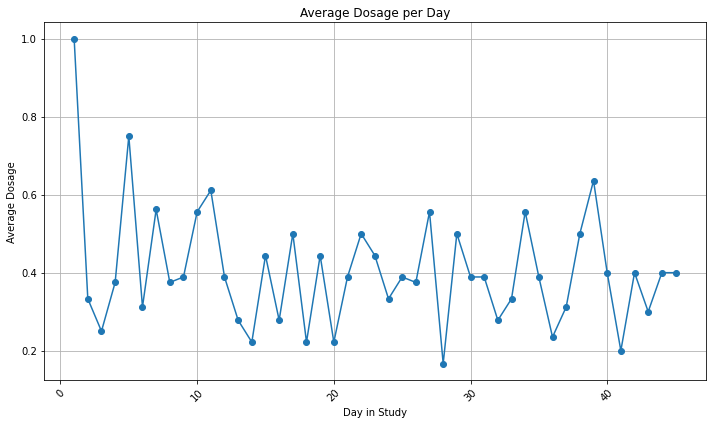

In [5]:
#Plot for average dosage per day
plt.figure(figsize=(10, 6))
plt.plot(daily_data['day_in_study'], daily_data['average_dosage'], marker='o')
plt.title('Average Dosage per Day')
plt.xlabel('Day in Study')
plt.ylabel('Average Dosage')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../../images/average_dosage.pdf')
plt.show()

## Plot 2: Variance within Users

Variation within users across the state features (1) brushing quality, (2) number of times they opened the app, (3) $\bar{B}$ exponentially discounted brushing in past week.

Computation process: 
1. Choose one state feature.$^*$
2. For chosen feature, calculate the mean of the feature for each user. 
3. For chosen feature, calculate the standard deviation.
4. Calculate the confidence interval per user per feature as follows
$$CI = \bar{x} \pm z \frac{s}{\sqrt{n}}$$
where $\bar{x}$ is the mean calculated in step 2, $s$ is the standard deviation from step 3, and $n$ is the number of data points for each user.
5. Repeat steps 1-4 for all features.


$^*$ Note that this process is slightly different for the feature `number of times they opened the app` since that is only recorded once at a daily level (instead of twice, like the other features). Thus, $n$ for this feature is half of that for the other features.

In [6]:
sim_env_data = sim_env_data.sort_values(by=['user_id','date'],ascending=[True,True])

#Clean user ID column for better visualization
sim_env_data['user_id_short'] = sim_env_data['user_id'].str.extract(r'([^@]+)')

#Create app usage data from user app engagement column separately because it is recorded once daily
user_app_usage = (sim_env_data.
                  groupby([
                      'user_id_short','date'
                  ])
                  ['state_app_engage'].
                  mean().
                  reset_index())

#Create dataframe with mean value per feature per user 
mean_per_user = (sim_env_data.
                 groupby('user_id_short')
                 [['state_b_bar',
                     'quality'
                  ]].
                 mean().
                 reset_index())

#Repeat process of mean calculation for state app engagement feature
mean_per_user['state_app_engage'] = (user_app_usage.groupby
                                     ('user_id_short')
                                     ['state_app_engage'].
                                     mean().
                                     reset_index()
                                     ['state_app_engage'])

#Create dataframe with standard deviation of each feature per user 
std_per_user = (sim_env_data.
                groupby('user_id_short')
                [['state_b_bar',
                    'quality'
                ]]
                .std()
                .reset_index())

std_per_user['state_app_engage'] = (user_app_usage.
                                    groupby('user_id_short')
                                    ['state_app_engage'].
                                    std().
                                    reset_index()
                                    ['state_app_engage'])

#Create dataframe with number of data points for each feature per user 
num_points_user = (sim_env_data.
                   groupby
                   ('user_id_short')
                   [['state_b_bar','quality'
                    ]].
                   count().
                   reset_index())

num_points_user['state_app_engage'] = (user_app_usage.
                                       groupby('user_id_short')
                                       ['state_app_engage'].
                                       size().
                                       reset_index()
                                       ['state_app_engage'])

#Compute lower bound and upper bound of confidence interval using formula listed above
z = 1.96
for col in ['state_b_bar', 'quality', 'state_app_engage']:
    mean_per_user[f'lower_bound_{col}'] = mean_per_user[col] - (z * std_per_user[col] / np.sqrt(num_points_user[col]))
    mean_per_user[f'upper_bound_{col}'] = mean_per_user[col] + (z * std_per_user[col] / np.sqrt(num_points_user[col]))

/var/folders/zs/lhqfdlj55y1dfvkqt4jrlwqr0000gn/T/ipykernel_13087/2355990662.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)
/var/folders/zs/lhqfdlj55y1dfvkqt4jrlwqr0000gn/T/ipykernel_13087/2355990662.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)
/var/folders/zs/lhqfdlj55y1dfvkqt4jrlwqr0000gn/T/ipykernel_13087/2355990662.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)


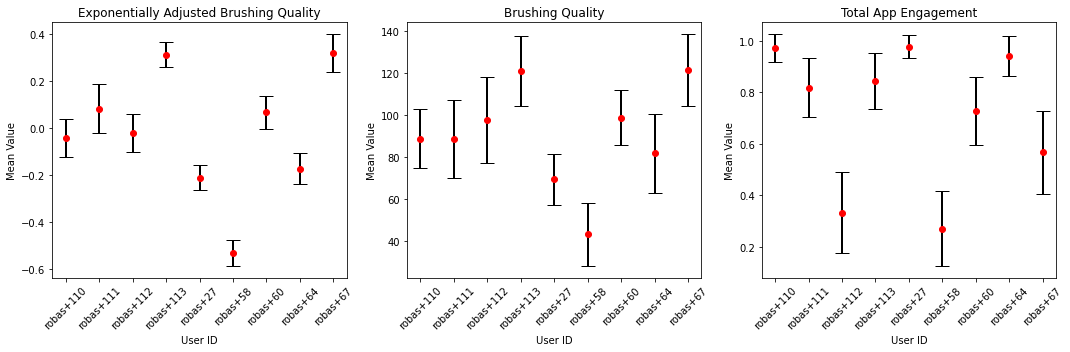

In [7]:
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

titles = {'state_b_bar':'Exponentially Adjusted Brushing Quality', 
          'quality':'Brushing Quality',
          'state_app_engage':'Total App Engagement'}

for i, col in enumerate(['state_b_bar', 'quality', 'state_app_engage']):
    ax = axes[i]
    ax.errorbar(
        mean_per_user['user_id_short'], 
        mean_per_user[col], 
        #confidence interval 
        yerr=[mean_per_user[col] - mean_per_user[f'lower_bound_{col}'],
              mean_per_user[f'upper_bound_{col}'] - mean_per_user[col]], 
        fmt='o', 
        color='red', 
        ecolor='black', 
        elinewidth=2, 
        capsize=7,
        label='Mean with 95% CI'
    )
    ax.set_title(titles[col])  
    ax.set_xlabel('User ID')
    ax.set_ylabel('Mean Value')
    ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)  

    # Annotate each bar with the corresponding value
    for bar, value in zip(ax.patches, mean_per_user[col]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.1f}', 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../../images/var_within_users.pdf')
plt.show()


/var/folders/zs/lhqfdlj55y1dfvkqt4jrlwqr0000gn/T/ipykernel_13087/3090567543.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)
/var/folders/zs/lhqfdlj55y1dfvkqt4jrlwqr0000gn/T/ipykernel_13087/3090567543.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)
/var/folders/zs/lhqfdlj55y1dfvkqt4jrlwqr0000gn/T/ipykernel_13087/3090567543.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)


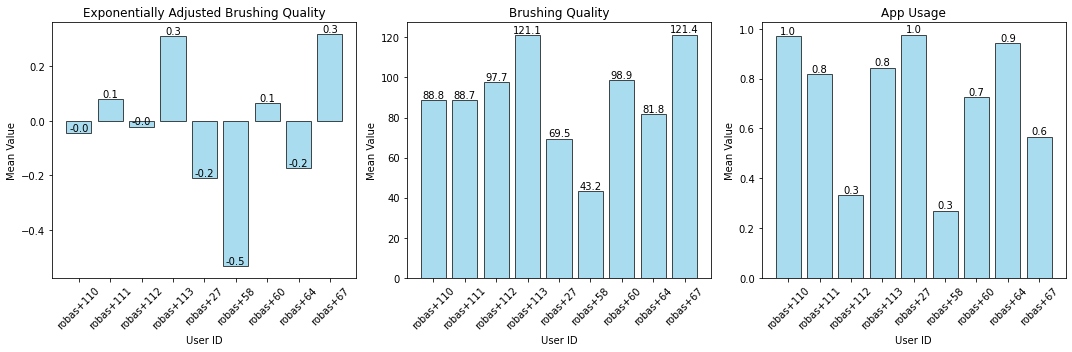

In [8]:
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

titles = {'state_b_bar':'Exponentially Adjusted Brushing Quality',
          'quality':'Brushing Quality',
          'state_app_engage':'App Usage'}

for i, col in enumerate(['state_b_bar', 'quality', 'state_app_engage']):
    ax = axes[i]
    ax.bar(mean_per_user['user_id_short'], mean_per_user[col], alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(titles[col]) 
    ax.set_xlabel('User ID')
    ax.set_ylabel('Mean Value')
    ax.set_xticklabels(mean_per_user['user_id_short'], rotation=45)  

    # Annotate each bar with the corresponding value
    for bar, value in zip(ax.patches, mean_per_user[col]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.1f}', 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Plot 3: Variance between users

How much variation there is between users (group by decision time). Compute variance and also have a plot for each statistic. Want average $X$ between users, where $X$ (1) is brushing quality, (2) number of times they opened the app, and (3) $\bar{B}$ exponentially discounted brushing in past week. For each plot, I am thinking x-axis is 70 users in the study and y-axis is each statistic for that user and we have some red line for mean and then dotted lines for upper and lower confidence (1.96 x SD).

Computation process: 
1. Choose feature. 
2. For each user, calculate the mean value for the feature. This produces a vector of values of size len(users).
3. Across all users, calculate the mean of the vector calculated in step 2. 
4. Across all users, calculate the standard deviation of the vector calculated in step 2.
5. Calculate the confidence interval per feature as follows
$$CI = \bar{x} \pm z \frac{s}{\sqrt{n}}$$
where $\bar{x}$ is the mean calculated in step 3, $s$ is the standard deviation from step 4, and $n$ is the number of users.
6. Repeat steps 1-5 for all state features.


to do:
- no x axis tiks, but still label as user id


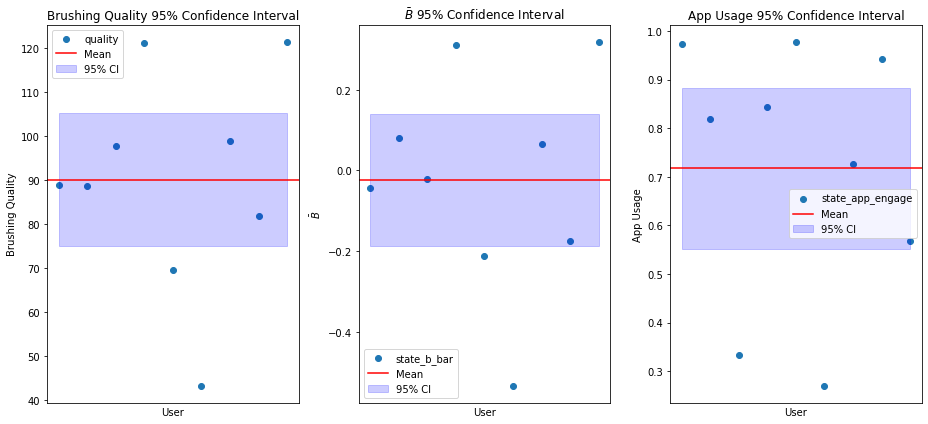

In [9]:
cols = ['quality', 'state_b_bar', 'state_app_engage']

titles = {'state_b_bar':r'$\bar{B}$', 
          'quality':'Brushing Quality',
          'state_app_engage':'App Usage'}

# Create a function to calculate the confidence interval
def mean_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std = np.std(data)
    n = len(data)
    h = std * 1.96 / np.sqrt(n)  # 1.96 is the z-score for 95% confidence
    return mean, mean - h, mean + h

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(13, 6))

# Plot each column
for i, col in enumerate(cols):
    data = mean_per_user[col]
    mean, lower, upper = mean_confidence_interval(data)
    
    axs[i].scatter(x= range(len(data)),y=data, label=col)
    axs[i].axhline(y=mean, color='r', linestyle='-', label='Mean')
    axs[i].fill_between(range(len(data)), lower, upper, color='b', alpha=0.2, label='95% CI')
    axs[i].set_title(f'{titles[col]} 95% Confidence Interval')
    axs[i].set_xlabel('User')
    axs[i].set_ylabel(f'{titles[col]}')
    axs[i].set_xticks([])
    axs[i].legend()

plt.tight_layout()
plt.savefig('../../images/var_between_users.pdf')
plt.show()

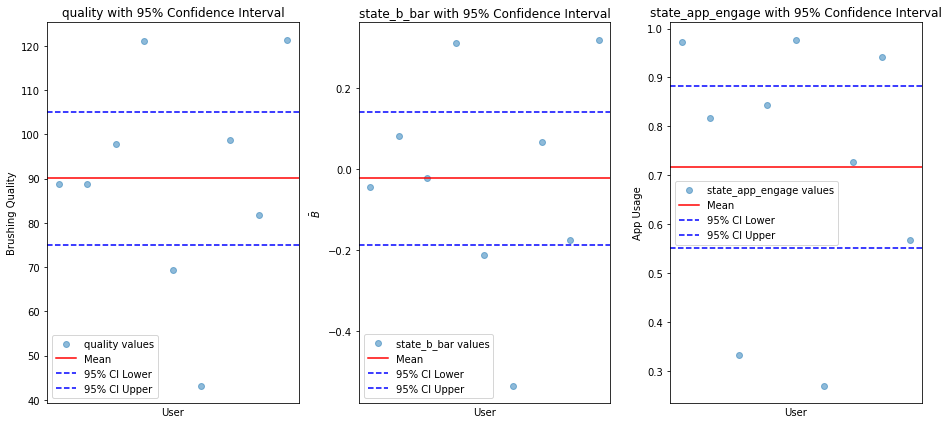

In [10]:
titles = {'state_b_bar':r'$\bar{B}$', 'quality':'Brushing Quality','state_app_engage':'App Usage'}

# Create a function to calculate the confidence interval
def mean_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std = np.std(data)
    n = len(data)
    h = std * 1.96 / np.sqrt(n)  # 1.96 is the z-score for 95% confidence
    return mean, mean - h, mean + h

# Create subplots with a different figsize to make plots narrower and taller
fig, axs = plt.subplots(1, 3, figsize=(13, 6))

# Plot each column
for i, col in enumerate(cols):
    data = mean_per_user[col]
    mean, lower, upper = mean_confidence_interval(data)
    
    axs[i].scatter(range(len(data)), data, alpha=0.5, label=f'{col} values')
    axs[i].axhline(y=mean, color='r', linestyle='-', label='Mean')
    axs[i].axhline(y=lower, color='b', linestyle='--', label='95% CI Lower')
    axs[i].axhline(y=upper, color='b', linestyle='--', label='95% CI Upper')
    axs[i].set_title(f'{col} with 95% Confidence Interval')
    axs[i].set_xlabel('User')
    axs[i].set_ylabel(f'{titles[col]}')
    axs[i].set_xticks([])
    axs[i].legend()
plt.tight_layout()
plt.show()

# Plot 4: Issue data

a spike every-time there was an issue with the RL algorithm (x axis is day in study, y axis is just a single spike corresponding to the color of the issue). Example issues can be action-selection / couldn't make a decision or couldn't update with that user's data and had to rely on fallback method
Are we assuming that there's only one issue per day?

- the y axis could be the number of users (ie. greater the num, bigger the spike) 

In [11]:
dates = set(sim_env_data['date'])

In [12]:
issue_data = pd.DataFrame(dates, columns=['date'])

# Generate a 'issue' column with 0 or 1, with 1 having a 30% probability
issue_data['issue'] = np.random.choice([0, 1], size=len(issue_data), p=[0.7, 0.3])

# Define the categories
categories = ['Issue A', 'Issue B', 'Issue C']

# Create a 'category' column
issue_data['category'] = np.where(
    issue_data['issue'] == 1, 
    np.random.choice(categories, size=len(issue_data)), 
    None
)

issue_data['num_users'] = np.where(
    issue_data['issue'] == 1, 
    np.random.randint(1, 11, size=len(issue_data)), 
    0
)


In [13]:
issue_data['date'] = pd.to_datetime(issue_data['date'])

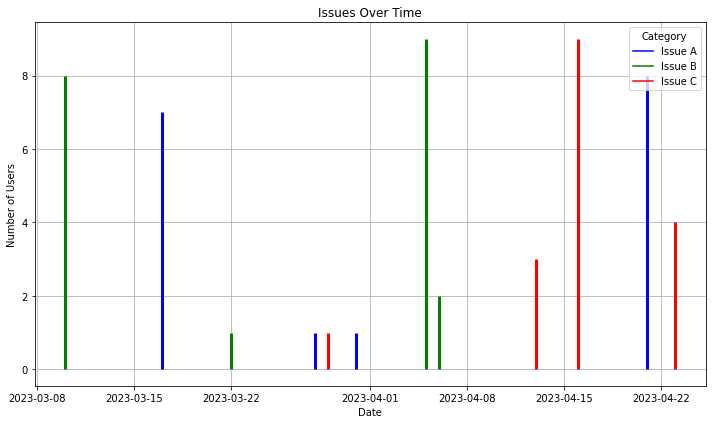

In [14]:
plt.figure(figsize=(10, 6))

category_colors = {
    'Issue A': 'blue',
    'Issue B': 'green',
    'Issue C': 'red'
}

handles = []
for category, color in category_colors.items():
    category_data = issue_data[(issue_data['issue'] == 1) & (issue_data['category'] == category)]
    handle = plt.vlines(
        x=category_data['date'], 
        ymin=0, 
        ymax=category_data['num_users'], 
        color=color, 
        linewidth=3, 
        label=category
    )
    handles.append(handle)

plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.title('Issues Over Time')
plt.grid(True)

plt.legend(
    handles=[plt.Line2D([0], [0], color=color, lw=1.5) for color in category_colors.values()], 
    labels=category_colors.keys(), 
    title='Category'
)

# Show the plot
plt.tight_layout()
plt.savefig('../../images/issues_plot.pdf')
plt.show()


# Plot 5: Staleness of the data

document the staleness of the data: 
### Part 1
(1) how many times out of the total number of decision points across all users ($T = 140$ decision points per user $\times$ 70 users in study) for action-selection. Idea to compute this value: compare and match the state for each user id and decision point in action selection data table (state used by algorithm to select action) with state in update data table (true current state).

Computation details: 
1. Merge the action-selection data and update data using the user ID and decision time as merge keys. 
2. For each user, 

3. For each user, calculate the total number of decision points. 
4. For each user,calculate the percentage of staleness as 
$$\% \text{ Staleness} = \frac{\text{mismatched data points}}{\text{total data points}}$$. 

### Part 2
 (2) Look at number of brushing sessions where we thought brushing time was 0 but it was because of delayed data and not because they did not brush. Idea to compute this value: compare each user's raw brushing session data with brushing time associated with that brushing window.
 
1. Merge the update data with the brush lightyear data. Join the two datasets on the user ID and decision time. Perform an inner join since some users have dropped out of the study and, hence, are not present in the brush
2. For each user, calculate the number of decision times where the quality from update data != the quality from the brush data. This also implies that update_data was zero. 
3. For each user, calculate the total number of times when update_data was zero. 
4. Compute percentage of misimputed brushing durations per user as 
$$\% \text{ Misimputed brushing sessions} = \frac{\text{mismatched data points}}{\text{total data points where brushing duration == 0}}$$. 


In [15]:
#Create list of all state features
state_cols = []
for col in update_data.columns:
    if col.startswith('state'):
        state_cols.append(col)
        
action_selection['date'] = pd.to_datetime(action_selection['decision_time']).dt.strftime("%Y-%m-%d")

#Merge action selection and update data
merged = (action_selection.merge(
            update_data[state_cols+['user_id','decision_time']],
            on=['user_id','decision_time'],
            how='inner',
            suffixes=('_action_selection', '_update_data')))

#Clean user ID column for better visualization
merged['user_id_short'] = merged['user_id'].str.extract(r'([^@]+)')
update_data['user_id_short'] = update_data['user_id'].str.extract(r'([^@]+)')

#Dataframe of decision points where app engagement from action-selection != update data.
diff = merged[merged['state_app_engage_action_selection'] !=merged['state_app_engage_update_data']]

#Dataframe with count of mismatch per user
diff_grouped = diff.groupby('user_id_short').size()

#Dataframe with total decision points per user
update_data_grouped = update_data.groupby('user_id_short').size()

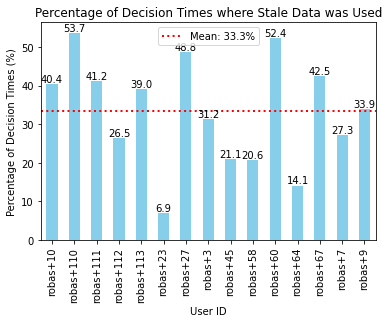

In [16]:
# Calculate the percentage ratio of mistmatch count/total decision point count
percentage_ratio = (diff_grouped / update_data_grouped) * 100

#Plotting
ax = percentage_ratio.plot(kind='bar', color='skyblue')
plt.xlabel('User ID')
plt.ylabel('Percentage of Decision Times (%)')
plt.title('Percentage of Decision Times where Stale Data was Used')

# Add numbers on top of the bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f')

# Calculate and add the mean line
mean_value = percentage_ratio.mean()
plt.axhline(mean_value, color='red', linestyle='dotted', linewidth=2, label=f'Mean: {mean_value:.1f}%')

plt.legend()
plt.savefig('../../images/staleness_plot_1.pdf')
plt.show()


In [17]:
len(diff)/len(update_data)*100

36.384704519119346

In [18]:
#Merge update data and brush data (inner join)
merged_brush = update_data.merge(brush_data[['user_id','decision_time','quality']], on = ['user_id','decision_time'],how = 'inner',suffixes=['_upd','_brsh'])

In [19]:
len(merged_brush[merged_brush['quality_upd']!=merged_brush['quality_brsh']][['quality_upd','quality_brsh']])

18

In [20]:
#Dataframe of decision times where the quality from update data != brush data
diff_brush = (merged_brush[merged_brush['quality_upd']!=merged_brush['quality_brsh']])

#Dataframe with count of all zero-value brush qualities in update data
all_zero_brush_qualities = merged_brush.query('quality_upd==0')

#Dataframe with count of mismatch per user
diff_grouped = diff_brush.groupby('user_id_short').size()

#Dataframe with total decision points per user
update_data_grouped = all_zero_brush_qualities.groupby('user_id_short').size()

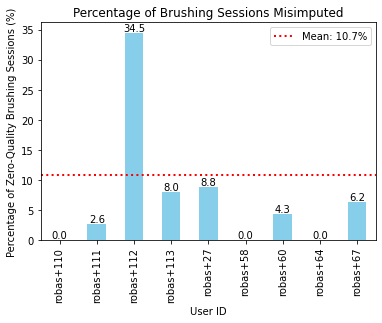

In [21]:
percentage_ratio = (diff_grouped / update_data_grouped) * 100

#Plotting
ax = percentage_ratio.plot(kind='bar', color='skyblue')
plt.xlabel('User ID')
plt.ylabel('Percentage of Zero-Quality Brushing Sessions (%)')
plt.title('Percentage of Brushing Sessions Misimputed')

# Add numbers on top of the bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f')

# Calculate and add the mean line
mean_value = percentage_ratio.mean()
plt.axhline(mean_value, color='red', linestyle='dotted', linewidth=2, label=f'Mean: {mean_value:.1f}%')

plt.legend()
plt.savefig('../../images/staleness_plot_2.pdf')
plt.show()
